In [1]:
#optiver volatility prediction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('/Users/ericp/OneDrive/Documents/GitHub/Optiver/train.csv')
test = pd.read_csv('/Users/ericp/OneDrive/Documents/GitHub/Optiver/test.csv')
order_book = pd.read_parquet('/Users/ericp/OneDrive/Documents/GitHub/Optiver/book_train.parquet/stock_id=0')
trade_book = pd.read_parquet('/Users/ericp/OneDrive/Documents/GitHub/Optiver/trade_train.parquet/stock_id=0')
stock_id = '0'
order_book['stock_id'] = stock_id
trade_book['stock_id'] = stock_id

In [3]:
train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [4]:
order_book.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0


In [5]:
order_book_time_id_5 = order_book[order_book['time_id'] == 5]

In [6]:
#create top of book wt avg
order_book_time_id_5['wt_avg1'] = (order_book_time_id_5['bid_price1'] * order_book_time_id_5['ask_size1'] + 
                                   order_book_time_id_5['ask_price1'] * order_book_time_id_5['bid_size1'])  / (order_book_time_id_5['bid_size1'] + 
                                                                                                               order_book_time_id_5['ask_size1'])

#create 2nd level wt avg
order_book_time_id_5['wt_avg2'] = (order_book_time_id_5['bid_price2'] * order_book_time_id_5['ask_size2'] + 
                                   order_book_time_id_5['ask_price2'] * order_book_time_id_5['bid_size2']) / (order_book_time_id_5['bid_size2'] + 
                                                                                                              order_book_time_id_5['ask_size2'])

#create mid point
order_book_time_id_5['mid_pt'] = (order_book_time_id_5['bid_price1'] + order_book_time_id_5['ask_price1']) / 2


In [9]:
#create log diffs
def logDiff(stock_prices):
    return np.log(stock_prices).diff()

#log diff
order_book_time_id_5['logDifferences'] = logDiff(order_book_time_id_5['wt_avg1'])
order_book_time_id_5['logDifferencesSq'] = order_book_time_id_5['logDifferences'] ** 2

In [10]:
order_book_time_id_5.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,wt_avg1,wt_avg2,mid_pt,logDifferences,logDifferencesSq
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0,1.001434,1.001390,1.001862,NaN,NaN
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0,1.001448,1.001390,1.001862,0.000014,1.979393e-10
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0,1.001448,1.001391,1.001862,0.000000,0.000000e+00
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,1.001443,1.001391,1.001862,-0.000005,2.655983e-11
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,1.001443,1.001391,1.001862,0.000000,0.000000e+00


In [11]:
sec_in_bucket = order_book.groupby('time_id')['seconds_in_bucket'].sum()

In [12]:
print('mean seconds in time_id is {}'.format(sec_in_bucket.mean()))
print('std dev seconds in time_id is {}'.format(sec_in_bucket.std()))

mean seconds in time_id is 70359.78825065274
std dev seconds in time_id is 22163.442000011495


In [13]:
min_in_bucket = sec_in_bucket / 60

In [14]:
print('Min minute in bucket is {}'.format(min_in_bucket.min()))
print("Max minute in bucket is {}".format(min_in_bucket.max()))

Min minute in bucket is 247.93333333333334
Max minute in bucket is 2716.2166666666667


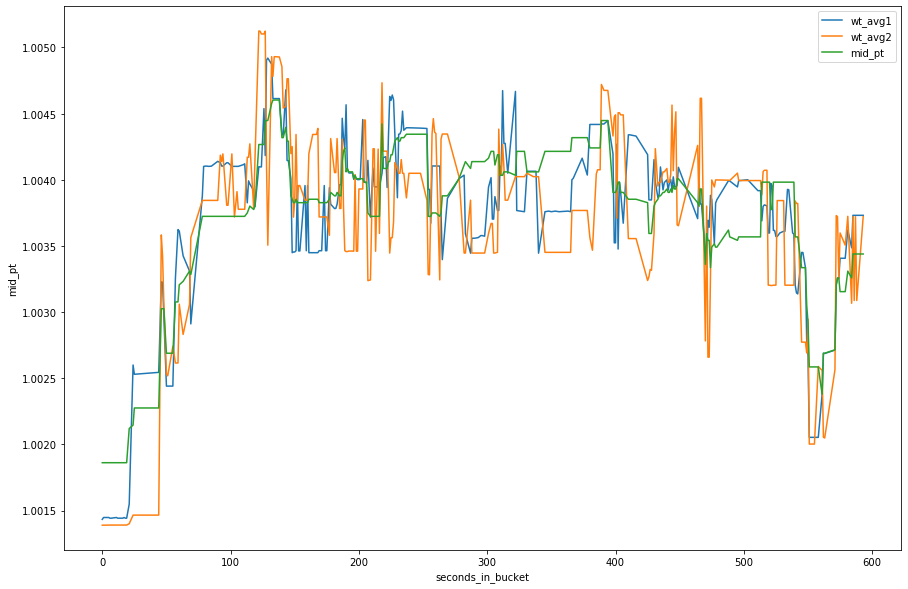

In [15]:
plt.figure(figsize = (15,10))
for col in ['wt_avg1', 'wt_avg2', 'mid_pt']:
    sns.lineplot(x = 'seconds_in_bucket', y = col, data = order_book_time_id_5, label = col)
plt.legend()
plt.show()

In [16]:
#garch 1,1 model
def var_n(gamma, alpha, beta, vol_long, ret, var_nminus1):
    return gamma * vol_long + (alpha * ret**2) + beta * var_nminus1
#expected vols
def expected_var(gamma, alpha, beta, vol_long, ret, var_nminus1, t):
    varn = var_n(gamma, alpha, beta, vol_long, ret, var_nminus1)
    return vol_long + (alpha + beta) ** t * (varn - vol_long)

In [17]:
#create realized vols for each time
def realized_vol(log_diffs):
    return np.sqrt(np.sum(log_diffs ** 2))

vol_long = realized_vol(order_book_time_id_5['logDifferences'])

In [18]:
#set coefficients
alpha = .20
beta = .50
gamma = .30

In [25]:
#calc var_nminus1
var_nminus1 = realized_vol(order_book_time_id_5['logDifferences'].tail(2))

In [28]:
order_book_time_id_5['logDifferences'].tail(1)

301    0.0
Name: logDifferences, dtype: float64

In [30]:
#calc var_n
n = var_n(gamma, alpha, beta, vol_long, order_book_time_id_5['logDifferences'].tail(1), var_nminus1)

In [35]:
expected_var(gamma, alpha, beta, vol_long, order_book_time_id_5['logDifferences'].tail(1), var_nminus1, 10000)

301    0.004499
Name: logDifferences, dtype: float64